# Tugas Data Mining Clustering Citra Udara

Anggota Kelompok


- 140810220036 - Alif Al Husaini


- 140810220043 - Darren Christian Liharja


- 140810220051 - Jason Natanael Krisyanto


## Preparation


Menginstall library yang diperlukan


In [1]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import randint
from collections import Counter
import pandas as pd
import pickle
from tabulate import tabulate
from PIL import Image
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.metrics import silhouette_score

## Data Understanding


Ektraksi data dari image agar kelompok kami dapat mengerti dengan data yang akan kami olah


In [2]:
directories = [
    ("DatasetDatmin/Beach", "Beach"),
    ("DatasetDatmin/Desert", "Desert"),
    ("DatasetDatmin/Residential", "Residential"),
    ("DatasetDatmin/Forest", "Forest"),
]

Pengecekan terlebih dahulu apakah setiap data bisa dibaca atau tidak


In [3]:
for directory, label in directories:
    print(f"Verifying data quality for {label}")
    images = os.listdir(directory)
    for image_name in images:
        try:
            image_path = os.path.join(directory, image_name)
            image = Image.open(image_path)
            image.verify()
        except Exception as e:
            print(f"Error with {image_name}: {e}")
    print(f"Finished checking {label}\n")

Verifying data quality for Beach
Finished checking Beach

Verifying data quality for Desert
Finished checking Desert

Verifying data quality for Residential
Finished checking Residential

Verifying data quality for Forest
Finished checking Forest



Mengecek jumlah gambar pada setiap kategori


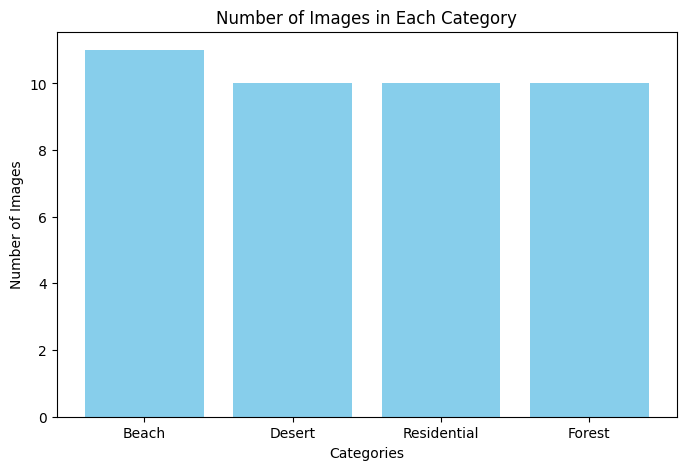

In [4]:
categories = []
num_images = []

for directory, label in directories:
    images = os.listdir(directory)
    categories.append(label)
    num_images.append(len(images))

# Plot jumlah gambar per kategori
plt.figure(figsize=(8, 5))
plt.bar(categories, num_images, color="skyblue")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Category")
plt.show()

In [5]:
data = []

for directory, label in directories:
    images = os.listdir(directory)
    for image_name in images[:10]:
        image_path = os.path.join(directory, image_name)
        image = Image.open(image_path)
        data.append([label, image_name, image.size, image.format])

# Membuat tabel dengan pandas
df = pd.DataFrame(data, columns=["Category", "Image Name", "Size", "Format"])

# Menampilkan tabel
print(tabulate(df, headers="keys", tablefmt="pretty", showindex=False))

+-------------+------------+------------+--------+
|  Category   | Image Name |    Size    | Format |
+-------------+------------+------------+--------+
|    Beach    |  001.jpg   | (256, 256) |  JPEG  |
|    Beach    |  003.jpg   | (256, 256) |  JPEG  |
|    Beach    |  004.jpg   | (256, 256) |  JPEG  |
|    Beach    |  006.jpg   | (256, 256) |  JPEG  |
|    Beach    |  009.jpg   | (256, 256) |  JPEG  |
|    Beach    |  010.jpg   | (256, 256) |  JPEG  |
|    Beach    |  028.jpg   | (256, 256) |  JPEG  |
|    Beach    |  042.jpg   | (256, 256) |  JPEG  |
|    Beach    |  067.jpg   | (256, 256) |  JPEG  |
|    Beach    |  072.jpg   | (256, 256) |  JPEG  |
|   Desert    |  001.jpg   | (256, 256) |  JPEG  |
|   Desert    |  002.jpg   | (256, 256) |  JPEG  |
|   Desert    |  003.jpg   | (256, 256) |  JPEG  |
|   Desert    |  004.jpg   | (256, 256) |  JPEG  |
|   Desert    |  005.jpg   | (256, 256) |  JPEG  |
|   Desert    |  007.jpg   | (256, 256) |  JPEG  |
|   Desert    |  009.jpg   | (2

Sample images from Beach


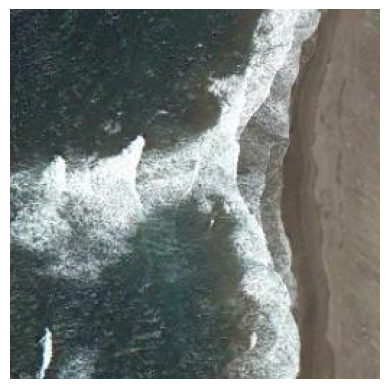

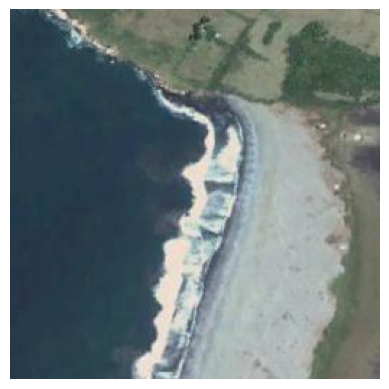

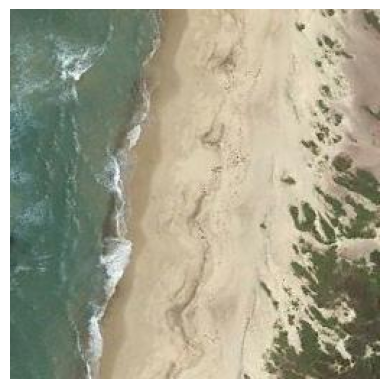

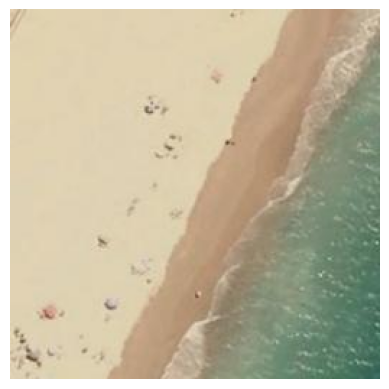

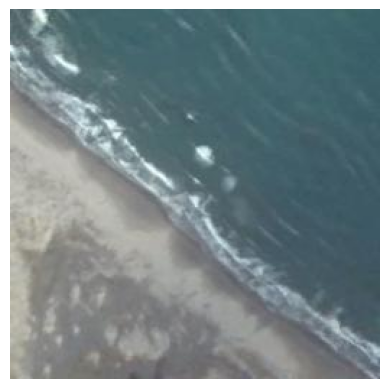

Sample images from Desert


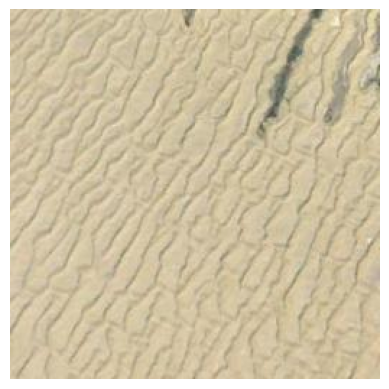

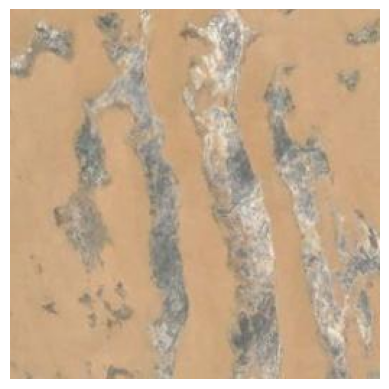

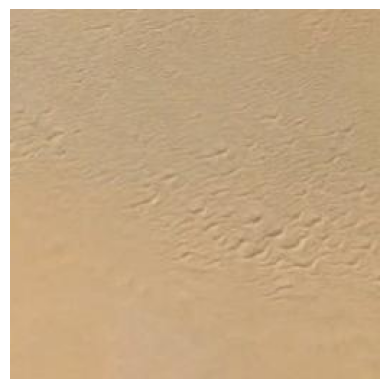

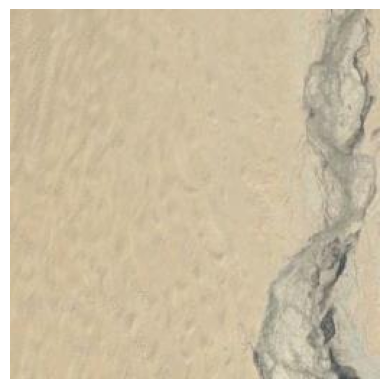

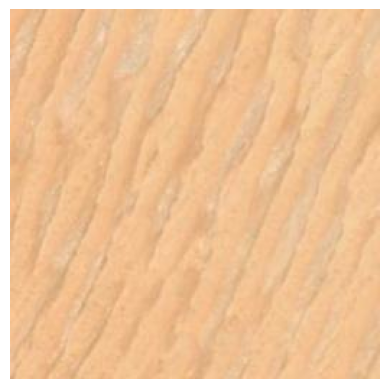

Sample images from Residential


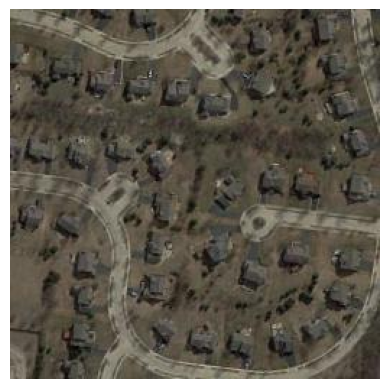

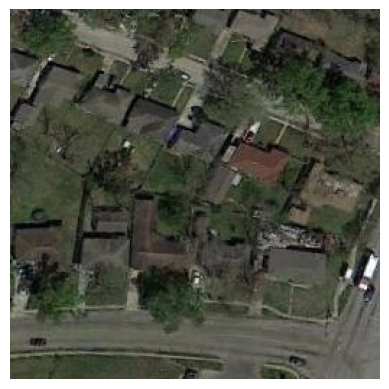

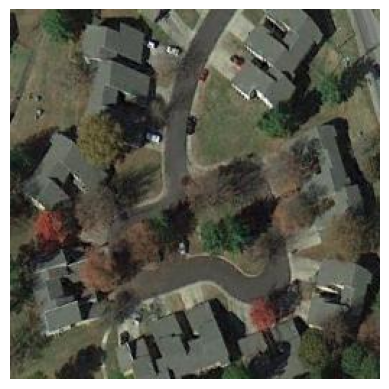

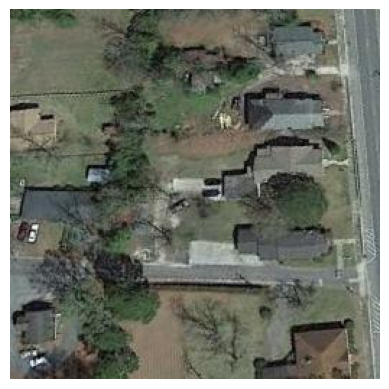

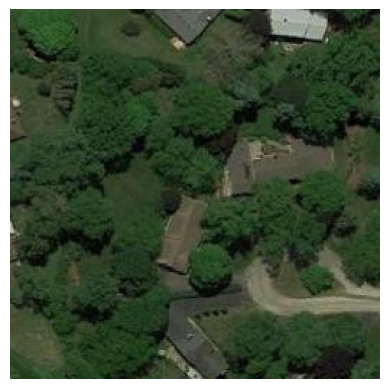

Sample images from Forest


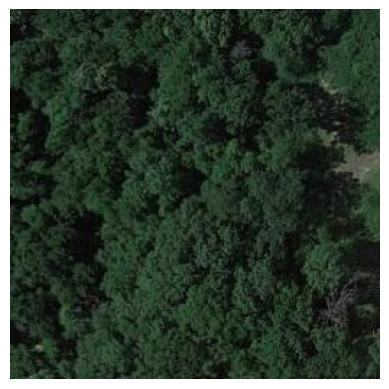

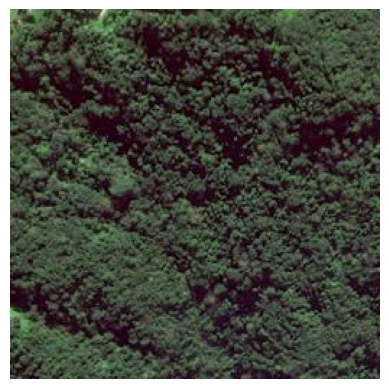

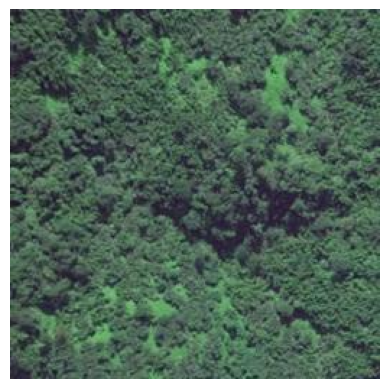

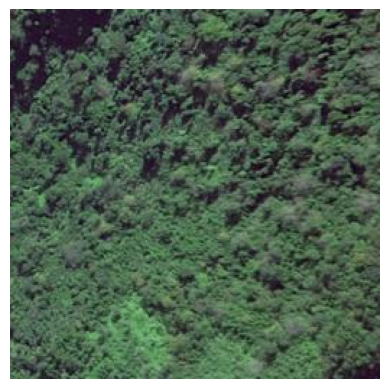

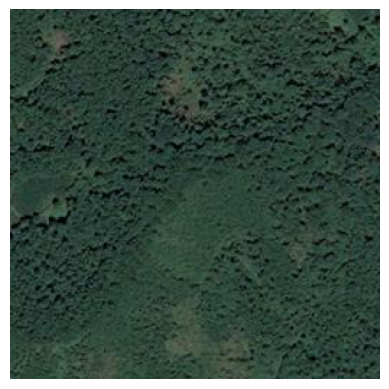

In [6]:
def show_images_from_category(directory, num_images=5):
    images = os.listdir(directory)[:num_images]
    for image_name in images:
        image_path = os.path.join(directory, image_name)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis("off")
        plt.show()


for directory, label in directories:
    print(f"Sample images from {label}")
    show_images_from_category(directory)

RGB Histogram for Beach


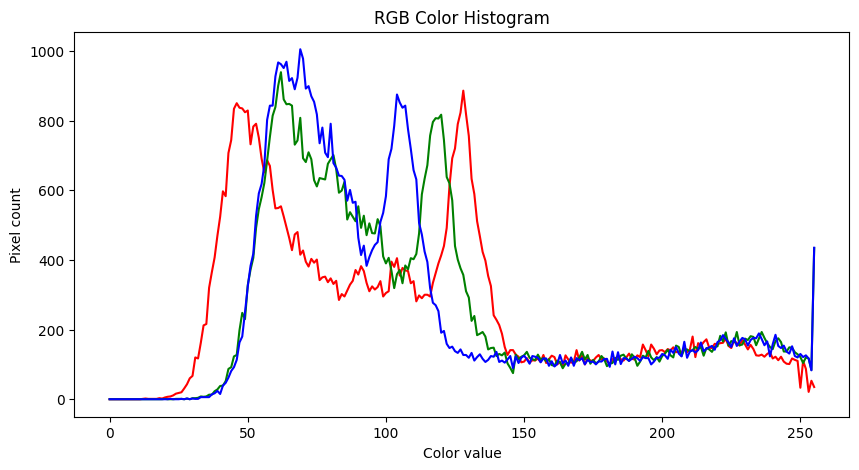

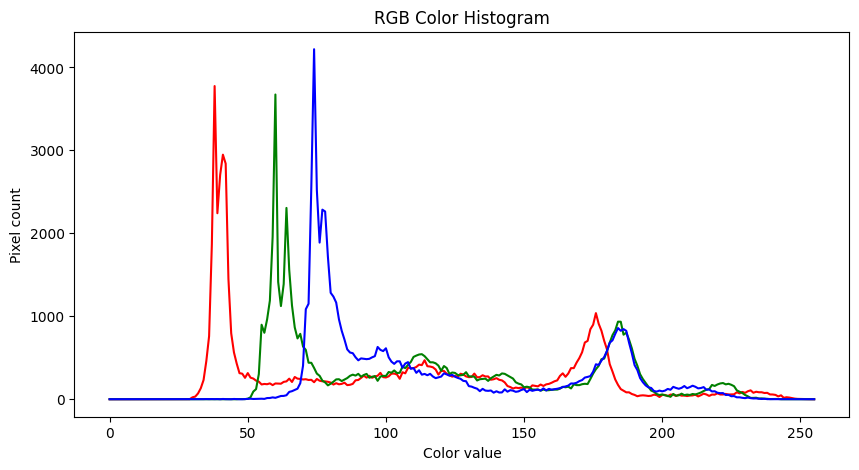

RGB Histogram for Desert


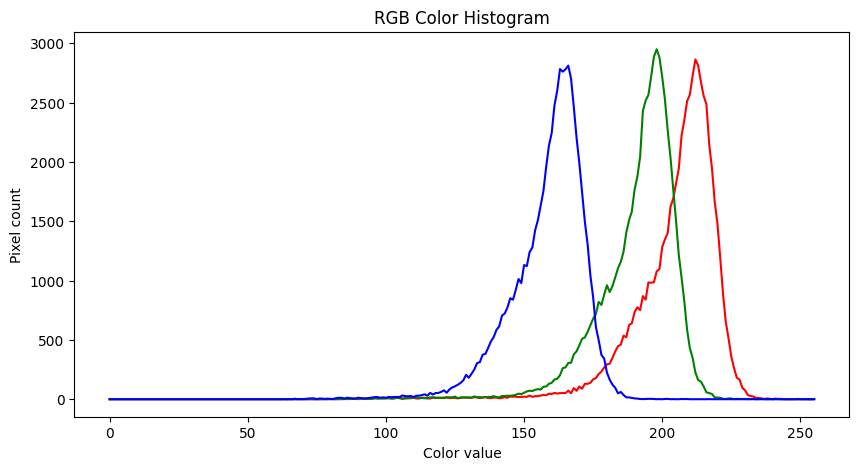

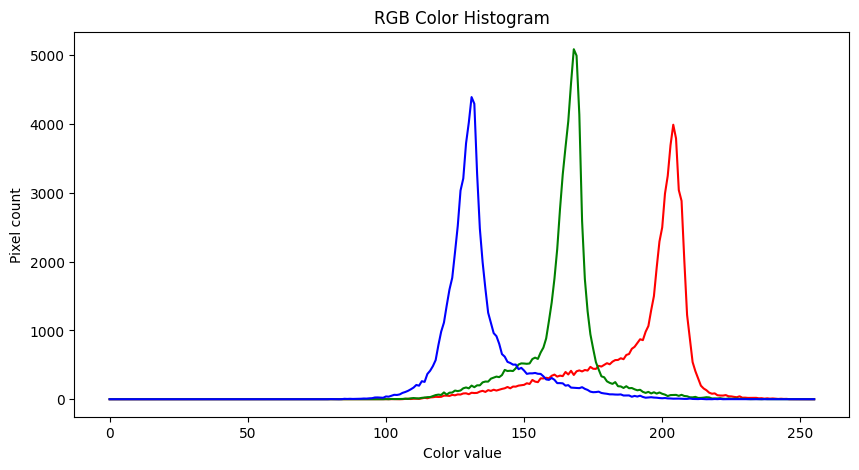

RGB Histogram for Residential


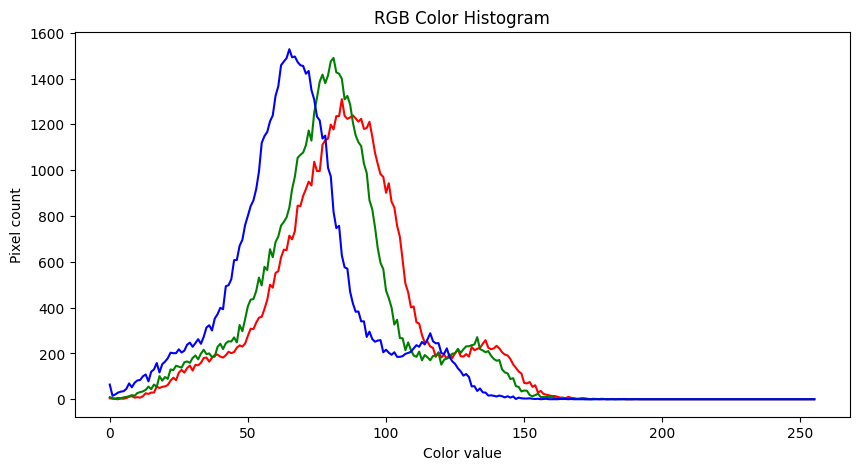

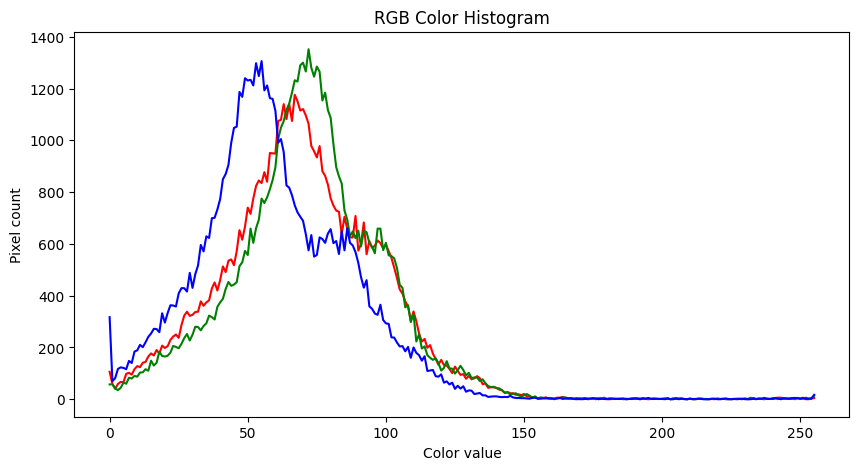

RGB Histogram for Forest


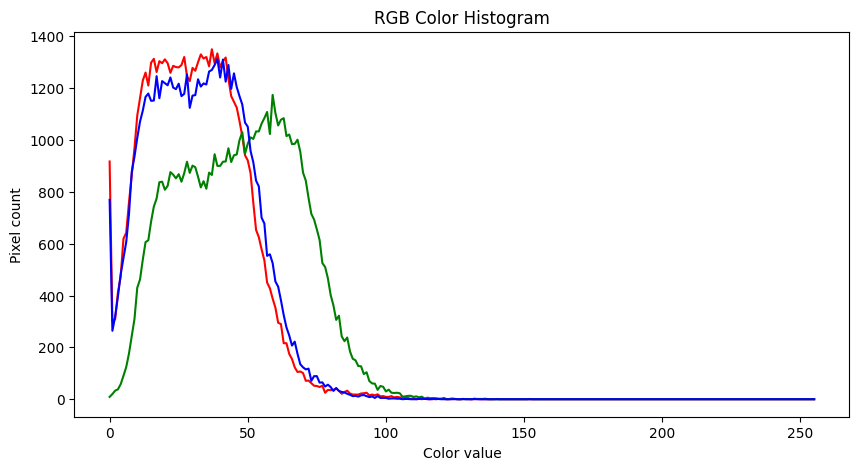

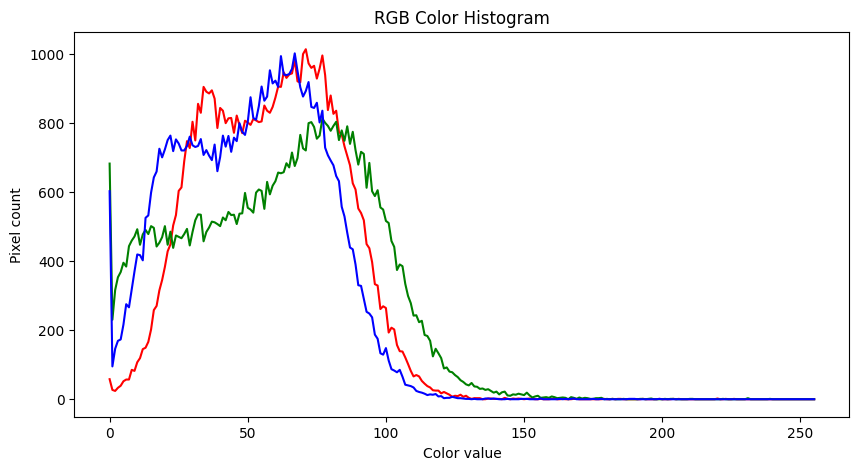

In [7]:
def plot_rgb_histogram(image):
    image_array = np.array(image)
    colors = ("r", "g", "b")
    channel_ids = (0, 1, 2)

    plt.figure(figsize=(10, 5))
    for channel_id, color in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            image_array[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=color)
    plt.title("RGB Color Histogram")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")
    plt.show()


for directory, label in directories:
    print(f"RGB Histogram for {label}")
    images = os.listdir(directory)[:2]
    for image_name in images:
        image_path = os.path.join(directory, image_name)
        image = Image.open(image_path)
        plot_rgb_histogram(image)

Mencari warna dominan dari tiap jenis gambar


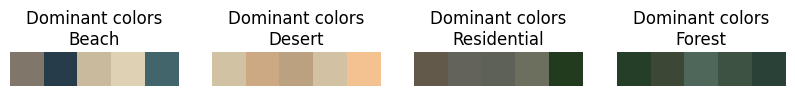

In [8]:
def get_dominant_color(image, k=4):
    image = image.resize((50, 50))
    image_array = np.array(image)
    pixels = np.reshape(image_array, (-1, 3))  # Flatten array menjadi (n, 3) untuk RGB

    counts = Counter([tuple(pixel) for pixel in pixels])
    dominant_color = counts.most_common(1)[0][0]
    return dominant_color


def plot_dominant_colors(directories, num_images=5):
    plt.figure(figsize=(10, 5))

    for i, (directory, label) in enumerate(directories):
        images = os.listdir(directory)[:num_images]
        dominant_colors = []

        for image_name in images:
            image_path = os.path.join(directory, image_name)
            image = Image.open(image_path)
            dominant_color = get_dominant_color(image)
            dominant_colors.append(dominant_color)

        plt.subplot(1, len(directories), i + 1)
        plt.imshow([dominant_colors])
        plt.title(f"Dominant colors\n{label}")
        plt.axis("off")

    plt.show()


plot_dominant_colors(directories)

## Data Preprocessing


Pada tahap ini, setelah memahami data yang diolah kelompok kami akan melakukan beberapa prosedur untuk membersihkan data


Mengolah data menjadi bentuk array


Preprocessing dengan denoise


In [9]:
def preprocess_image(image, target_size=(200, 200)):
    image = image.resize(target_size)
    image_array = np.array(image)
    denoised_image = cv2.fastNlMeansDenoisingColored(image_array, None, 10, 10, 7, 21)
    return Image.fromarray(denoised_image)

Preprocessing dengan sharpen kernel


In [10]:
def preprocess_image_sharpen_kernel(image, target_size=(200, 200)):
    image = image.resize(target_size)
    image_array = np.array(image)
    denoised_image = cv2.fastNlMeansDenoisingColored(image_array, None, 10, 10, 7, 21)
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(denoised_image, -1, sharpening_kernel)
    return Image.fromarray(sharpened_image)

Preprocessing dengan unsharp mask


In [11]:
def preprocess_image_unsharp_mask(image, target_size=(200, 200)):
    image = image.resize(target_size)
    image_array = np.array(image)
    denoised_image = cv2.fastNlMeansDenoisingColored(image_array, None, 10, 10, 7, 21)
    blurred_image = cv2.GaussianBlur(denoised_image, (5, 5), 0)
    sharpened_image = cv2.addWeighted(denoised_image, 1.5, blurred_image, -0.5, 0)
    return Image.fromarray(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))

Perbandingan proses preprocessing


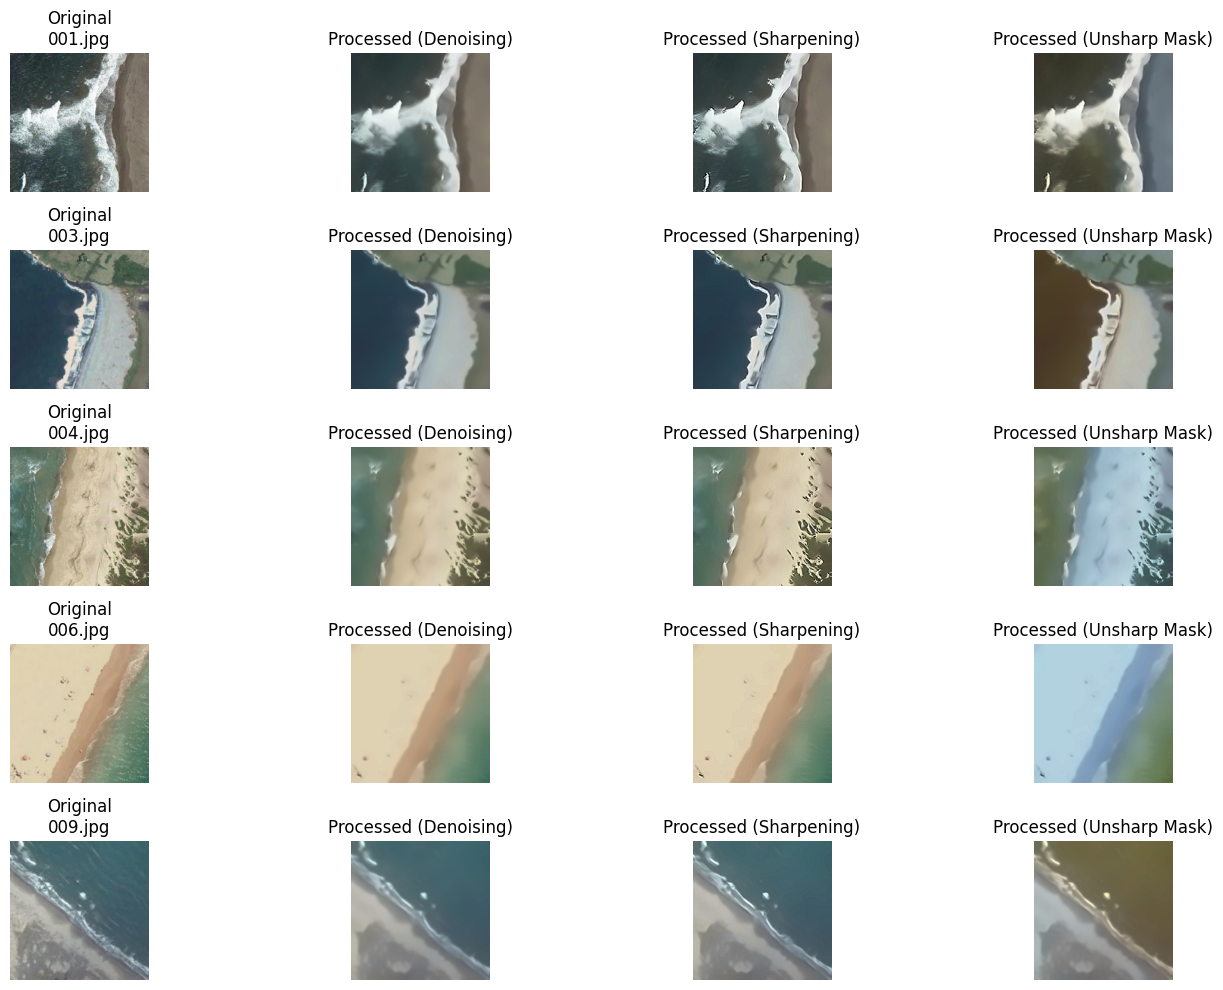

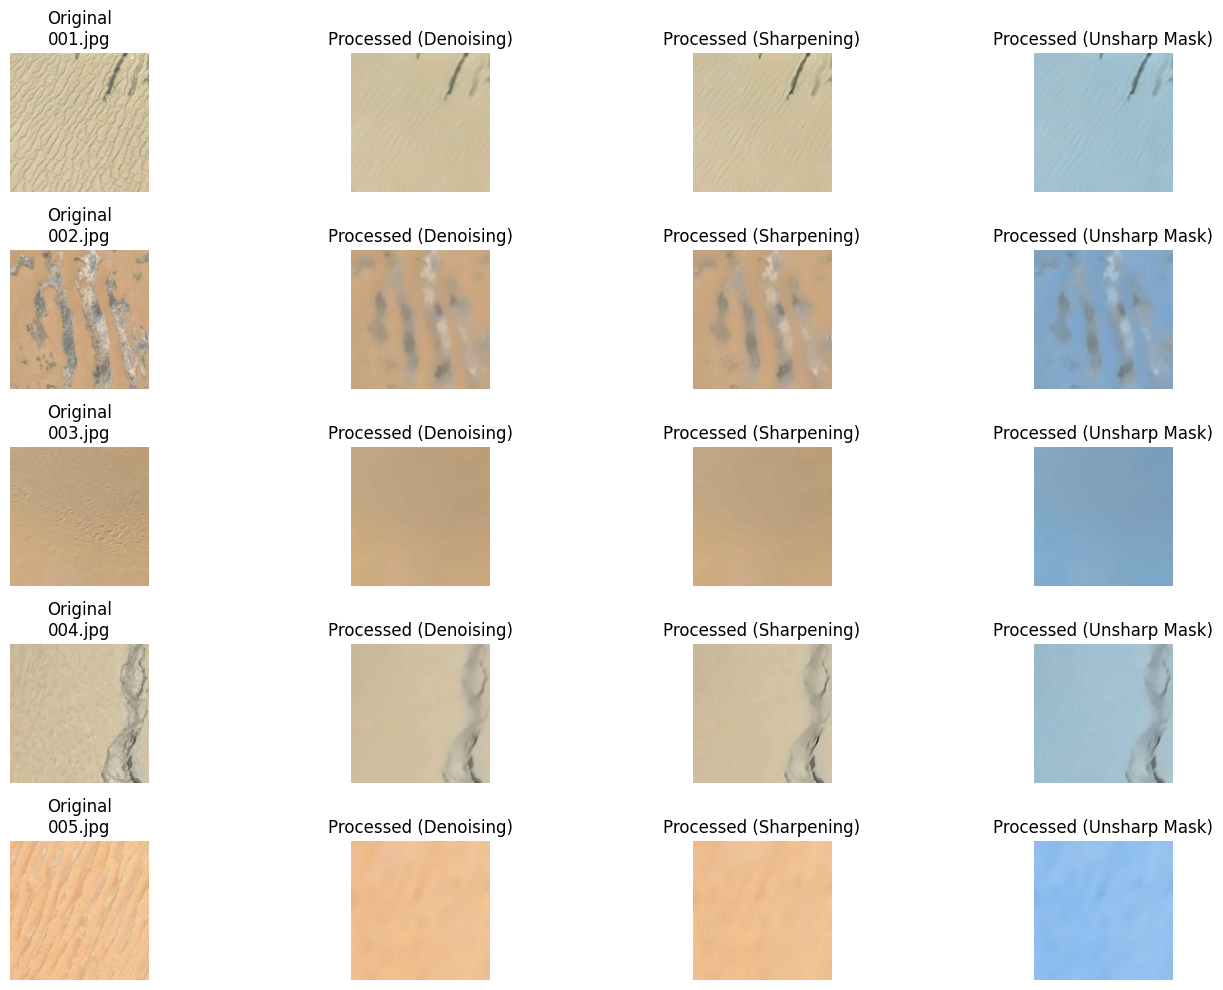

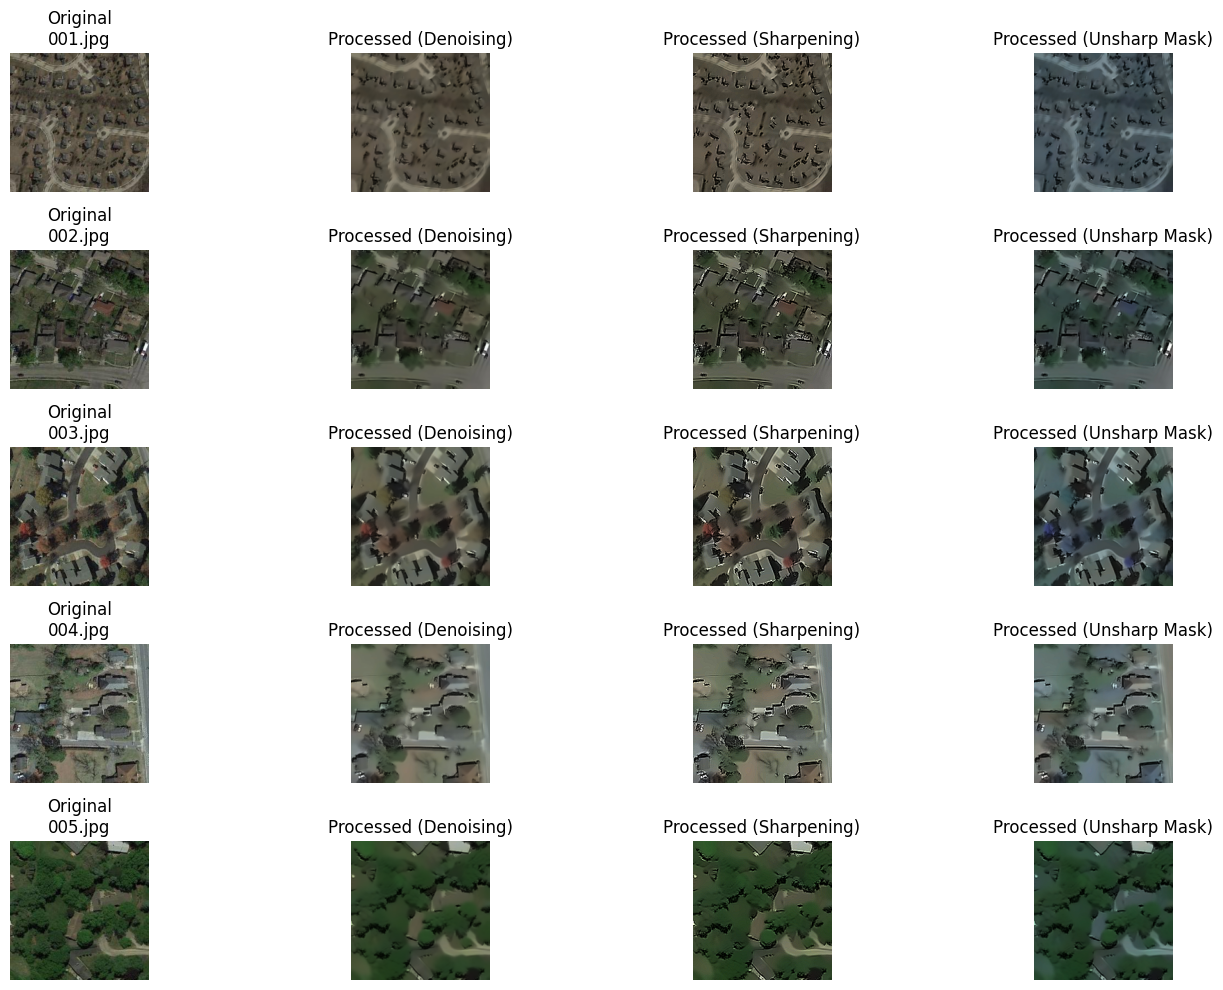

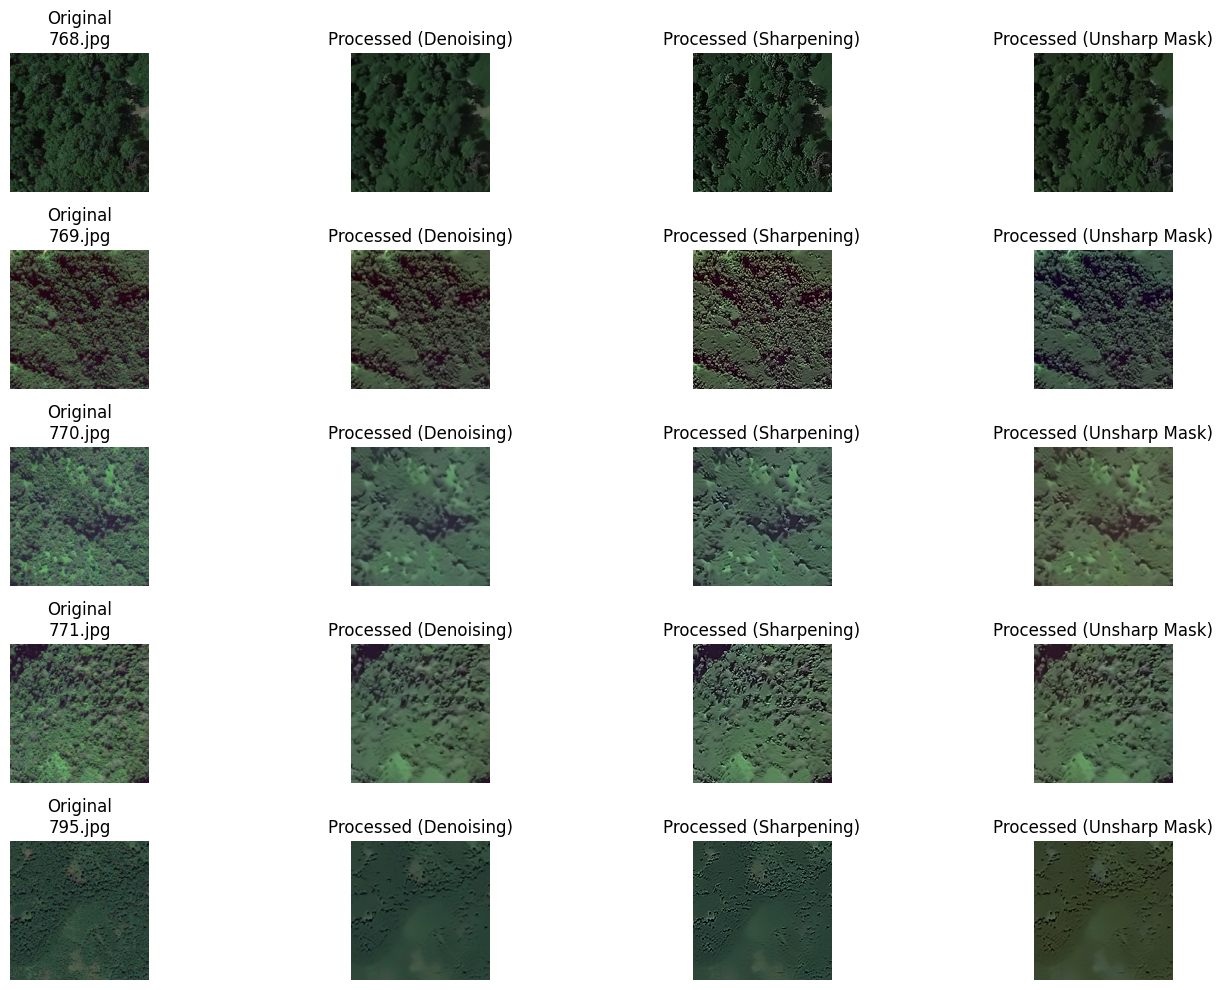

In [12]:
def preprocess_and_compare_images(directory, target_size=(200, 200), num_images=5):
    images = os.listdir(directory)[:num_images]  # Ambil sejumlah gambar yang ditentukan
    plt.figure(figsize=(15, 10))

    for i, image_name in enumerate(images):
        image_path = os.path.join(directory, image_name)
        original_image = Image.open(image_path)

        # Proses gambar dengan tiga metode
        processed_image_denoise = preprocess_image(original_image, target_size)
        processed_image_sharpen = preprocess_image_sharpen_kernel(
            original_image, target_size
        )
        processed_image_unsharp = preprocess_image_unsharp_mask(
            original_image, target_size
        )

        # Tampilkan gambar asli dan gambar yang sudah diproses
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(original_image)
        plt.title(f"Original\n{image_name}")
        plt.axis("off")

        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(processed_image_denoise)
        plt.title("Processed (Denoising)")
        plt.axis("off")

        plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(processed_image_sharpen)
        plt.title("Processed (Sharpening)")
        plt.axis("off")

        plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(processed_image_unsharp)
        plt.title("Processed (Unsharp Mask)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Proses dan bandingkan gambar untuk setiap direktori
for directory, label in directories:
    preprocess_and_compare_images(directory, target_size=(200, 200), num_images=5)

Dari hasil di atas bisa dilihat bahwa preprocessed dengan sharpening (sharpen kernel) membuat gambar lebih tajam dan kontras dibanding preprocessed lain. Sehingga, kami memutuskan untuk menggunakan preprocessed dengan sharpen kernel untuk hasil klustrerisasi yang maksimal.


In [13]:
def preprocess_image(image_path: str, image_size=(75, 75)) -> np.ndarray:
    """Memuat dan memproses gambar."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Tidak dapat memuat gambar dari {image_path}")

    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_denoised = cv2.GaussianBlur(img, (5, 5), 0)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = cv2.filter2D(img_denoised, -1, kernel)

    return img_sharpened

In [48]:
import pandas as pd

# Fungsi untuk menampilkan array gambar yang telah diproses dalam tabel
def display_image_arrays_as_table(processed_images):
    data = []  # List untuk menyimpan data tabel

    for category, images in processed_images.items():
        for idx, img in enumerate(images):
            # Menyimpan ukuran dan data gambar sebagai tuple
            data.append({
                "Kategori": category,
                "Gambar Index": idx + 1,
                "Ukuran": img.shape,
                "Array": img.flatten()  # Mengonversi array 2D menjadi 1D untuk mempermudah tampilan
            })

    # Mengonversi list ke DataFrame Pandas
    df = pd.DataFrame(data)

    # Menampilkan tabel
    print(df)

# Menampilkan array gambar yang telah diproses dalam tabel
display_image_arrays_as_table(processed_images)


   Kategori  Gambar Index       Ukuran  \
0     Beach             1  (75, 75, 3)   
1     Beach             2  (75, 75, 3)   
2     Beach             3  (75, 75, 3)   
3     Beach             4  (75, 75, 3)   
4     Beach             5  (75, 75, 3)   
5     Beach             6  (75, 75, 3)   
6     Beach             7  (75, 75, 3)   
7     Beach             8  (75, 75, 3)   
8     Beach             9  (75, 75, 3)   
9     Beach            10  (75, 75, 3)   
10    Beach            11  (75, 75, 3)   

                                                Array  
0   [60, 64, 77, 59, 62, 69, 51, 59, 67, 46, 50, 6...  
1   [43, 65, 80, 42, 64, 79, 48, 70, 83, 44, 66, 8...  
2   [86, 107, 95, 84, 104, 93, 81, 102, 89, 78, 10...  
3   [211, 187, 160, 210, 189, 157, 211, 198, 164, ...  
4   [93, 112, 116, 90, 109, 113, 79, 99, 104, 87, ...  
5   [212, 195, 151, 211, 194, 150, 214, 197, 153, ...  
6   [213, 194, 174, 224, 209, 187, 232, 213, 187, ...  
7   [120, 103, 89, 123, 106, 86, 124, 108, 88, 

### Ekstraksi Fitur


In [14]:
def extract_texture_features(img: np.ndarray) -> np.ndarray:
    # Mengubah gambar menjadi grayscale
    gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Menghitung GLCM (Gray Level Co-occurrence Matrix) untuk gambar
    glcm = graycomatrix(
        gray_img,
        distances=[1],
        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
        levels=256,
    )

    # Mengekstrak properti GLCM: contrast, dissimilarity, homogeneity, energy, correlation
    contrast = graycoprops(glcm, "contrast").flatten()
    dissimilarity = graycoprops(glcm, "dissimilarity").flatten()
    homogeneity = graycoprops(glcm, "homogeneity").flatten()
    energy = graycoprops(glcm, "energy").flatten()
    correlation = graycoprops(glcm, "correlation").flatten()

    # Menggabungkan semua properti GLCM menjadi satu vektor fitur
    texture_features = np.hstack(
        [contrast, dissimilarity, homogeneity, energy, correlation]
    )

    return texture_features

In [15]:
# Fungsi untuk mengekstrak fitur dari gambar
def extract_features(img: np.ndarray) -> np.ndarray:
    try:
        # Mengubah bentuk gambar menjadi array 2D
        pixels = img.reshape(-1, 3)

        # Mengonversi RGB ke HSV
        # hsv_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        # hsv_pixels = hsv_img.reshape(-1, 3)

        # Ekstraksi fitur tekstur
        # texture_features = extract_texture_features(img)

        # Memastikan bahwa fitur tekstur dapat diperluas dengan benar
        # if texture_features.ndim == 1:
        #     texture_features_expanded = np.tile(texture_features, (pixels.shape[0], 1))
        # else:
        #     texture_features_expanded = texture_features  # Jika sudah 2D

        # Menggabungkan semua fitur
        # combined_features = np.hstack([pixels, hsv_pixels, texture_features_expanded])
        combined_features = np.hstack([pixels])

        # Mencetak total jumlah piksel/fitur
        print(
            f"Total number of pixels/features extracted: {combined_features.shape[0]}"
        )

        return combined_features
    except Exception as e:
        print(f"Error in extracting features: {e}")
        return np.array([])  # Mengembalikan array kosong jika terjadi kesalahan

### Modeling


In [16]:
def initialize_centroids(data, k):
    """Inisialisasi centroid awal untuk KMeans."""
    centroids = []
    centroids.append(data[np.random.randint(0, len(data))])

    for _ in range(1, k):
        distances = np.array(
            [min([np.linalg.norm(x - c) ** 2 for c in centroids]) for x in data]
        )
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        next_centroid_index = np.searchsorted(cumulative_probabilities, r)
        centroids.append(data[next_centroid_index])

    return np.array(centroids)

In [17]:
def euclidean_distance(point1, point2):
    """Hitung jarak Euclidean antara dua titik."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [18]:
def kmeans_manual(features, k, centroids, max_iters=100):
    """Melakukan algoritma KMeans secara manual."""
    for it in range(max_iters):
        # Assign cluster
        labels = np.zeros(features.shape[0])
        for i in range(features.shape[0]):
            distances = np.array(
                [euclidean_distance(features[i], centroid) for centroid in centroids]
            )
            labels[i] = np.argmin(distances)

        # Update centroid
        new_centroids = np.zeros(centroids.shape)
        for j in range(k):
            if np.any(labels == j):
                new_centroids[j] = features[labels == j].mean(axis=0)

        # Periksa konvergensi
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids
    return centroids, labels

In [19]:
# Fungsi untuk memperbarui centroid
def update_centroids(features, clusters, k):
    # Memperbarui centroid berdasarkan rata-rata fitur yang berada dalam setiap cluster
    new_centroids = np.zeros((k, features.shape[1]))
    for i in range(k):
        cluster_points = features[clusters == i]
        if len(cluster_points) > 0:
            new_centroids[i] = np.mean(cluster_points, axis=0)
    return new_centroids

In [20]:
# Fungsi untuk memeriksa apakah centroid sudah konvergen
def has_converged(old_centroids, new_centroids, tolerance=1e-6):
    # Memeriksa apakah centroid telah konvergen (berhenti berubah signifikan)
    distances = np.linalg.norm(new_centroids - old_centroids, axis=1)
    return np.all(distances < tolerance)

In [21]:
# Fungsi untuk memuat dataset dan melakukan clustering
def train_kmeans_on_dataset(directories, k):
    """Memproses semua gambar dalam direktori dan melatih KMeans."""
    all_features = []
    for directory in directories:
        for filename in os.listdir(directory[0]):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(directory[0], filename)
                img = preprocess_image(img_path)
                features = extract_features(img)
                all_features.append(features)

    all_features = np.vstack(all_features)
    initial_centroids = initialize_centroids(all_features, k)
    print("Initial centroids calculated.")
    
    centroids, cluster_labels = kmeans_manual(all_features, k, initial_centroids)
    return centroids, cluster_labels

In [22]:
def visualize_clusters(image, cluster_labels, k, centroids):
    """Membuat gambar baru berdasarkan hasil cluster, mewarnai piksel sesuai dengan warna dominan dari centroid."""
    clustered_rgb_image = np.zeros_like(image, dtype=np.uint8)
    height, width, _ = image.shape
    cluster_labels_reshaped = cluster_labels.reshape(height, width)

    for cluster in range(k):
        dominant_color = centroids[cluster].astype(int)
        clustered_rgb_image[cluster_labels_reshaped == cluster] = dominant_color

    return clustered_rgb_image

In [41]:
def segment_image(image_path, centroids):
    """Melakukan segmentasi gambar berdasarkan centroid yang telah dihitung."""
    img = preprocess_image(image_path, (200,200))
    features = extract_features(img) / 255.0
    cluster_labels = np.zeros(features.shape[0])
    
    for i in range(features.shape[0]):
        distances = np.array([euclidean_distance(features[i], centroid / 255.0) for centroid in centroids])
        cluster_labels[i] = np.argmin(distances)
    
    segmented_img = visualize_clusters(img, cluster_labels, len(centroids), centroids)
    return segmented_img


In [42]:
def show_image_with_legend(image, centroids, k, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

    legend_labels = []
    for i in range(k):
        color_patch = plt.Rectangle((0, 0), 1, 1, fc=centroids[i] / 255.0)
        legend_labels.append(color_patch)
    
    plt.subplots_adjust(bottom=0.2)
    plt.legend(legend_labels, [f'Cluster {i+1}' for i in range(k)],
               loc="lower center", ncol=k, bbox_to_anchor=(0.5, -0.1), 
               frameon=False, borderpad=1, handletextpad=1, columnspacing=1)

    plt.show()

In [43]:
# Menghitung Silhouette Score
def calculate_silhouette(image_path, centroids):
    """Menghitung Silhouette Score dari gambar yang disegmentasi."""
    img = preprocess_image(image_path, (200, 200))
    features = extract_features(img) / 255.0
    labels = np.zeros(features.shape[0])
    
    for i in range(features.shape[0]):
        distances = np.array([euclidean_distance(features[i], centroid / 255.0) for centroid in centroids])
        labels[i] = np.argmin(distances)

    # Hitung Silhouette Score
    silhouette_avg = silhouette_score(features, labels)
    return silhouette_avg

In [44]:
# Definisikan direktori dataset
directories = [
    ('DatasetDatmin/Beach', 'Beach')
]

# Melatih KMeans pada dataset
k = 3  # Jumlah cluster
centroids, clusters = train_kmeans_on_dataset(directories, k)

# Menampilkan centroid yang ditemukan
print("Centroids found:")
print(centroids)
print(clusters)

Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Initial centroids calculated.
Centroids found:
[[ 68.92670286  85.88677196  81.67566634]
 [204.60743258 196.56389892 173.04336377]
 [138.19833979 138.59573879 121.56325401]]
[0. 0. 0. ... 1. 1. 1.]


Total number of pixels/features extracted: 40000


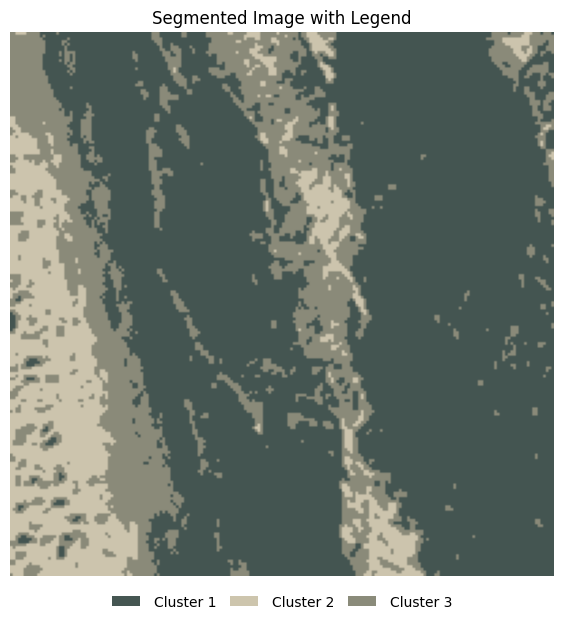

Total number of pixels/features extracted: 40000
Silhouette Score: 0.554


In [45]:
test_image_path = 'DatasetDatmin/Beach2/054.jpg'  # Ganti dengan path ke gambar yang ingin disegmentasi
segmented_image = segment_image(test_image_path, centroids)

# Tampilkan hasil segmentasi
show_image_with_legend(segmented_image, centroids, k, 'Segmented Image with Legend')
silhouette_avg = calculate_silhouette(test_image_path, centroids)
print(f'Silhouette Score: {silhouette_avg:.3f}')

In [30]:
directories2 = [
    ('DatasetDatmin/Agriculture', 'Agriculture')
]

# Melatih KMeans pada dataset
k = 4  # Jumlah cluster
centroids2, clusters2 = train_kmeans_on_dataset(directories2, k)

# Menampilkan centroid yang ditemukan
print("Centroids found:")
print(centroids2)
print(clusters2)

Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Total number of pixels/features extracted: 5625
Initial centroids calculated.
Centroids found:
[[133.47554715 130.66306404 114.73757093]
 [ 93.64620389  98.31517752  85.50716313]
 [ 43.40224334  57.4942099   44.56940333]
 [170.32364341 163.13294574 144.7881137 ]]
[0. 0. 0. ... 2. 2. 2.]


Total number of pixels/features extracted: 40000


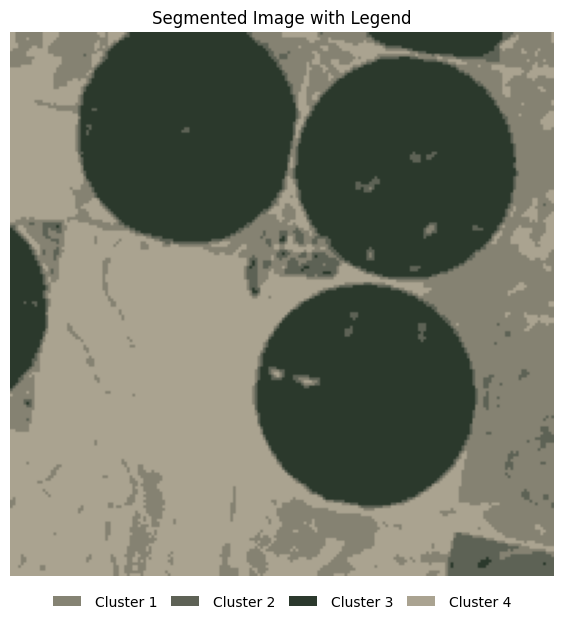

Total number of pixels/features extracted: 40000
Silhouette Score: 0.595


In [40]:
test_image_path = 'DatasetDatmin/Agriculture/001.jpg'  # Ganti dengan path ke gambar yang ingin disegmentasi
segmented_image = segment_image(test_image_path, centroids2)

# Tampilkan hasil segmentasi dengan legenda
show_image_with_legend(segmented_image, centroids2, k, 'Segmented Image with Legend')
silhouette_avg = calculate_silhouette(test_image_path, centroids)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Total number of pixels/features extracted: 5625


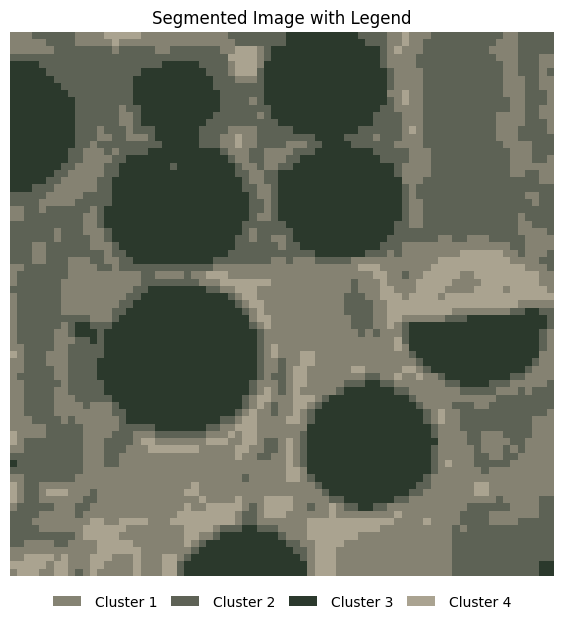

Total number of pixels/features extracted: 5625
Silhouette Score: 0.491


In [32]:
test_image_path = 'DatasetDatmin/Agriculture/005.jpg'  # Ganti dengan path ke gambar yang ingin disegmentasi
segmented_image = segment_image(test_image_path, centroids2)

# Tampilkan hasil segmentasi dengan legenda
show_image_with_legend(segmented_image, centroids2, k, 'Segmented Image with Legend')
silhouette_avg = calculate_silhouette(test_image_path, centroids)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Total number of pixels/features extracted: 5625


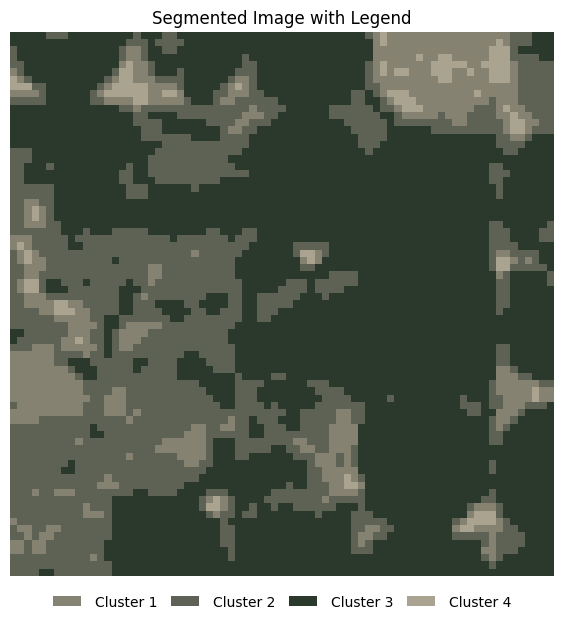

Total number of pixels/features extracted: 5625
Silhouette Score: 0.524


In [33]:
test_image_path = 'DatasetDatmin/Agriculture/010.jpg'  # Ganti dengan path ke gambar yang ingin disegmentasi
segmented_image = segment_image(test_image_path, centroids2)

# Tampilkan hasil segmentasi dengan legenda
show_image_with_legend(segmented_image, centroids2, k, 'Segmented Image with Legend')
silhouette_avg = calculate_silhouette(test_image_path, centroids)
print(f'Silhouette Score: {silhouette_avg:.3f}')